In [4]:
import os
import random
import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

import warnings
warnings.filterwarnings("ignore")

In [5]:
project_name = os.environ.get('DOMINO_PROJECT_NAME')

# Former is directory structure for imported github repo, latter for local domino project
if os.path.isdir('/mnt/data'):
    data_directory = os.path.join('/mnt', 'data', project_name)
else:
    data_directory = os.path.join('/domino', 'datasets', 'local', project_name)

In [41]:
# Import the errors caught using regex pattern from application. 
# This will be our training data with examples for each error type
error_file_paths = [file for file in os.listdir(os.path.join(data_directory, 'support-bundle-summary/')) if file.endswith('.csv')]
errors_df = [pd.read_csv(os.path.join(data_directory, 'support-bundle-summary', file)) for file in error_file_paths]
errors_df = pd.concat(errors_df, ignore_index=True)
errors_df = errors_df[['Context', 'Error_Type']]
errors_df.shape

(23304, 8)

In [46]:
support_bundles_directory = os.path.join(data_directory, 'support-bundles')
support_bundles = os.listdir(support_bundles_directory)
support_bundles = [x for x in support_bundles if '.zip' not in x]

In [48]:
resource_usage_directory = os.path.join(data_directory, 'resource-usage-by-day/')
resource_usage_csv_files = os.listdir(resource_usage_directory)
resource_usage_df = pd.concat([pd.read_csv(os.path.join(resource_usage_directory, f)) for f in resource_usage_csv_files], ignore_index=True)

In [50]:
# Capture non-error and non-failure execution_ids
no_errors = resource_usage_df[resource_usage_df['status'].isin(['Running', 'Succeeded'])]

In [62]:
# Identifying all relevant file paths to extract 'no error' training lines 
existing_bundles = list(set(no_errors.run_id) & set(support_bundles))
existing_bundles_file_paths = [os.path.join(data_directory, 'support-bundles', bundle) for bundle in existing_bundles]

all_file_paths = [
    os.path.join(root, file)
    for directory in existing_bundles_file_paths
    for root, dirs, files in os.walk(directory)
    for file in files
]

In [69]:
# Open each file and extract the lines
def open_all_files(paths):
    with open(paths, 'r') as f:
        raw_content = f.readlines()

    raw_content = [line.strip() for line in raw_content]
    
    return(raw_content)

all_content = [open_all_files(path) for path in all_file_paths]
all_content = [line for file in all_content for line in file]

# Filter out lines with an insignificant amount of information
num_chars = 10
all_content = list(filter(lambda word: len(word) > num_chars, all_content))

len(all_content)

In [72]:
# Sample the non-errors such that the resulting data is 50% errors, 50% non errors
wanted_num_non_errors = errors_df.shape[0]
indices = random.sample(range(len(all_content)), wanted_num_non_errors)
target_content = [all_content[idx] for idx in indices]

no_errors_df = pd.DataFrame({"Context" : target_content, "Error_Type" : ["none" for i in target_content]})

In [75]:
# Create the final dataset
all_data = pd.concat([errors_df, no_errors_df])
all_data.columns = ['text', 'label']
all_data.shape

(46608, 2)

In [92]:
# To avoid obscene training times, the below is used to train the values
def stratified_sample(df, stratifying_col, n):
    def sample_func(group):
        if len(group) < int(n/df[stratifying_col].nunique()):
            return group.sample(int(n/df[stratifying_col].nunique()), replace=True)
        else:
            return group.sample(int(n/df[stratifying_col].nunique()))
    return df.groupby(stratifying_col, group_keys=False).apply(sample_func)

# Get stratified sample with target number of rows
n = 30000
all_data_small = stratified_sample(all_data, 'label', n)

df_train_small, df_test_small = train_test_split(all_data_small, test_size=0.1, stratify=all_data_small["label"])

dir_name = os.path.join(data_directory, 'classification_data')

if not os.path.exists(dir_name):
    os.makedirs(dir_name)

In [ ]:
# Save out the training and test data, as well as all the extracted errors/non-errors
df_train_small.to_csv(os.path.join(dir_name, datetime.now().strftime('%Y%m%d_%H%M%S') + "_train_small.csv"), index=False)
df_test_small.to_csv(os.path.join(dir_name, datetime.now().strftime('%Y%m%d_%H%M%S') + "_test_small.csv"), index=False)
all_data.to_csv(os.path.join(dir_name, datetime.now().strftime('%Y%m%d_%H%M%S') + '_extracted_data.csv'), index=False)

# Creating/Training the Model

In [8]:
df_train_small = pd.read_csv(os.path.join(data_directory, 'classification_data', '20231106_172505_train_small.csv'))
df_test_small = pd.read_csv(os.path.join(data_directory, 'classification_data', '20231106_172505_test_small.csv'))
df_test_small = df_test_small[df_test_small['text'].notna()]

In [7]:
# df_train_small = df_train_small[1:100]
# df_test_small = df_test_small[1:100]

In [14]:
text_to_label = {'none':0, 'cluster':1, 'domino':2, 'user':3}
label_to_text = {str(label):text for text, label in text_to_label.items()}
    
df_train_small['label'] = df_train_small['label'].apply(lambda x: text_to_label[x])
df_test_small['label'] = df_test_small['label'].apply(lambda x: text_to_label[x])

In [6]:
# Load up the model
import log_error_classifier
from log_error_classifier import HuggingFaceClassifier

#model = HuggingFaceClassifier(path_or_pretrained='bert-base-cased', num_labels=4)
model = HuggingFaceClassifier(path_or_pretrained='/mnt/artifacts/models/log_classification_20231106_212241/')

In [15]:
# Train the model
model.train(df=df_train_small)

100%|██████████| 10095/10095 [32:46<00:00,  5.13it/s]


In [29]:
model_directory = os.path.join('/mnt', 'artifacts', 'models', 'log_classification_'+datetime.now().strftime('%Y%m%d_%H%M%S'))

os.makedirs(model_directory)
model.model.save_pretrained(model_directory)
model.tokenizer.save_pretrained(model_directory)

('/mnt/artifacts/models/log_classification_20231106_214832/tokenizer_config.json',
 '/mnt/artifacts/models/log_classification_20231106_214832/special_tokens_map.json',
 '/mnt/artifacts/models/log_classification_20231106_214832/vocab.txt',
 '/mnt/artifacts/models/log_classification_20231106_214832/added_tokens.json',
 '/mnt/artifacts/models/log_classification_20231106_214832/tokenizer.json')

In [ ]:
#testing

In [9]:
text = df_test_small['text'].to_list()
predictions, probabilities = model.predict(text)

100%|██████████| 94/94 [00:21<00:00,  4.47it/s]


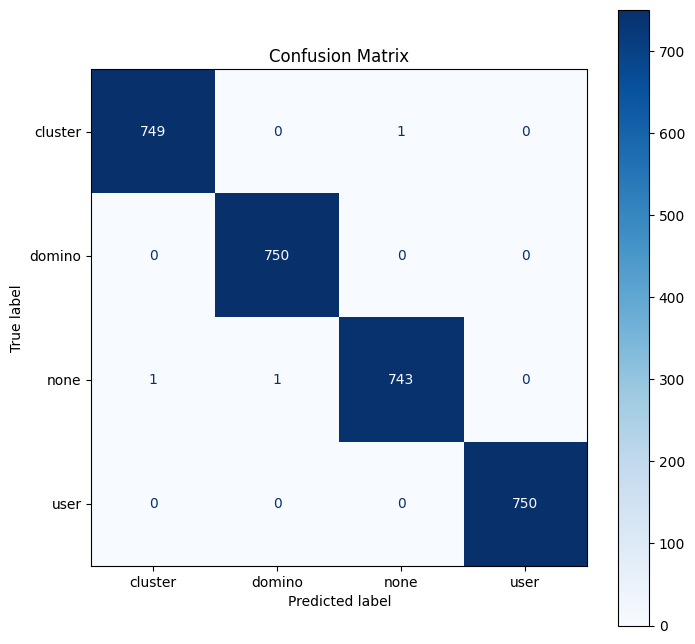

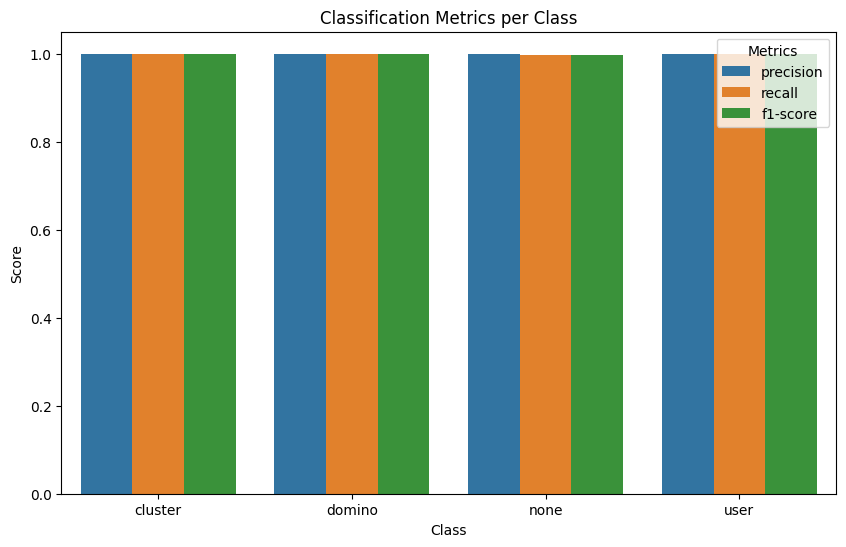

In [27]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Assuming 'df' is your DataFrame with 'predictions' and 'labels' columns
predictions = [label_to_text[str(pred)] for pred in predictions]
labels = [label_to_text[str(label)] for label in df_test_small['label'].to_list()]

# Generate the classification report and the confusion matrix
report = classification_report(labels, predictions, output_dict=True)
conf_matrix = confusion_matrix(labels, predictions)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(labels)).plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()

# Extract the precision, recall, and F1 score for each class
metrics_df = pd.DataFrame(report).transpose().reset_index()
metrics_df.rename({'index': 'class'}, axis=1, inplace=True)

# Remove the 'support' column and the last three rows which contain the averages
metrics_df = metrics_df[:-3].drop('support', axis=1)

# Melt the dataframe for seaborn barplot
metrics_melted = pd.melt(metrics_df, id_vars=['class'], var_name='metrics', value_name='values')

# Plot precision, recall, and F1-score
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x='class', y='values', hue='metrics')
plt.title('Classification Metrics per Class')
plt.ylabel('Score')
plt.xlabel('Class')
plt.legend(title='Metrics', loc='upper right')
plt.show()
